# Turnover

## Install packages

In [2]:
import sys

In [3]:
!{sys.executable} -m pip install -r requirements.txt

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import os
import quiz_helper
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### data bundle

In [6]:
import os
import quiz_helper
from zipline.data import bundles

In [7]:
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..','data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], quiz_helper.EOD_BUNDLE_NAME)
bundles.register(quiz_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build pipeline engine

In [8]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(quiz_helper.EOD_BUNDLE_NAME)
engine = quiz_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [9]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

# Get Returns data

In [10]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [11]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

## get pricing data into a dataframe

In [12]:
returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000
2011-01-21 00:00:00+00:00,0.007873,-0.041038,0.005544,-0.017911,0.000000,0.010642,-0.000853,-0.001952,-0.006569,-0.004113,...,0.000000,0.000615,0.015825,-0.003048,-0.000872,0.000000,-0.007590,0.009325,0.024020,0.000000


## Sector data helper function
We'll create an object for you, which defines a sector for each stock.  The sectors are represented by integers.  We inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [13]:
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype
class Sector(Classifier):
    dtype = int64_dtype
    window_length = 0
    inputs = ()
    missing_value = -1

    def __init__(self):
        self.data = np.load('../../data/project_4_sector/data.npy')

    def _compute(self, arrays, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value,
        )

In [14]:
sector = Sector()

## We'll use 2 years of data to calculate the factor

**Note:** Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open.

In [15]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

## Create smoothed momentum factor

In [16]:
from zipline.pipeline.factors import Returns
from zipline.pipeline.factors import SimpleMovingAverage


# create a pipeline called p
p = Pipeline(screen=universe)
# create a factor of one year returns, deman by sector, then rank
factor = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()). #we use the custom Sector class that we reviewed earlier
    rank().
    zscore()
)


# Use this factor as input into SimpleMovingAverage, with a window length of 5
# Also rank and zscore (don't need to de-mean by sector, s)
factor_smoothed = (
    SimpleMovingAverage(inputs=[factor], window_length=5).
    rank().
    zscore()
)

# add the unsmoothed factor to the pipeline
p.add(factor, 'Momentum_Factor')
# add the smoothed factor to the pipeline too
p.add(factor_smoothed, 'Smoothed_Momentum_Factor')

## visualize the pipeline

Note that if the image is difficult to read in the notebook, right-click and view the image in a separate tab.

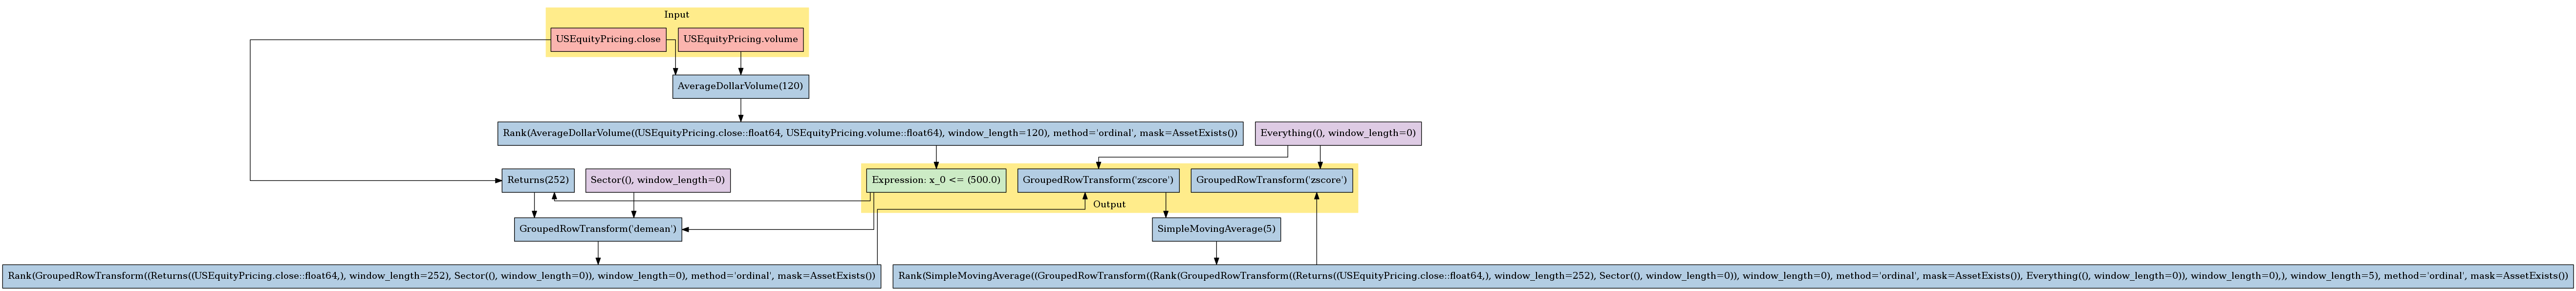

In [17]:
p.show_graph(format='png')

## run pipeline and view the factor data

In [18]:
df = engine.run_pipeline(p, factor_start_date, universe_end_date)

In [19]:
df.head()

Momentum_Factor  \
2014-01-03 00:00:00+00:00 Equity(0 [A])            1.499391   
                          Equity(1 [AAL])          1.602797   
                          Equity(2 [AAP])          0.376694   
                          Equity(3 [AAPL])        -1.484618   
                          Equity(4 [ABBV])         0.915884   

                                            Smoothed_Momentum_Factor  
2014-01-03 00:00:00+00:00 Equity(0 [A])                     1.484618  
                          Equity(1 [AAL])                   1.573252  
                          Equity(2 [AAP])                   0.206813  
                          Equity(3 [AAPL])                 -1.477232  
                          Equity(4 [ABBV])                  0.945429

## Evaluate Factors

We'll go over some tools that we can use to evaluate alpha factors.  To do so, we'll use the [alphalens library](https://github.com/quantopian/alphalens)


## Import alphalens

In [20]:
import alphalens as al

## Get price data

Note, we already got the price data and converted it to returns, which we used to calculate a factor.  We'll retrieve the price data again, but won't convert these to returns.  This is because we'll use alphalens functions that take their input as prices and not returns.

## Define the list of assets
Just to make sure we get the prices for the stocks that have factor values, we'll get the list of assets, which may be a subset of the original universe

In [21]:
# get list of stocks in our portfolio (tickers that identify each stock)
assets = df.index.levels[1].values.tolist()
print(f"stock universe number of stocks {len(universe_tickers)}, and number of stocks for which we have factor values {len(assets)}")

stock universe number of stocks 490, and number of stocks for which we have factor values 490


In [22]:
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

In [23]:
pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets, #notice that we used assets instead of universe_tickers; in this example, they're the same
        factor_start_date, # notice we're using the same start and end dates for when we calculated the factor
        universe_end_date)

In [24]:
factor_names = df.columns
print(f"The factor names are {factor_names}")

# Use a dictionary to store each dataframe, one for each factor and its associated forward returns
factor_data = {}
for factor_name in factor_names:
    print("Formatting factor data for: " + factor_name)
    # Get clean factor and forward returns for each factor
    # Choose single period returns (daily returns)
    factor_data[factor_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=df[factor_name],
        prices=pricing,
        periods=[1])

The factor names are Index(['Momentum_Factor', 'Smoothed_Momentum_Factor'], dtype='object')
Formatting factor data for: Momentum_Factor
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Smoothed_Momentum_Factor
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Turnover Analysis

One aspect of a good factor is one that does not incur as much transaction costs compared to other factors. How do some factors incur more transaction costs than others?  Well, if a factor requires that we constantly rebalance our portfolio by buying and selling every day, then it would be more costly compared to a factor that only requires us to make trades once per quarter.  If we look at the factor ranks (sort the stocks by their factor score on each day, then give them ranks 1,2,3...N), we can see how these factor ranks change from day to day. If, for instance, we have a portfolio of 3 stocks, and their ranks do not change for several days (for example: Stock A is always ranked 3rd, stock B is always ranked 1st, and stock C is always ranked 2nd), that means we would not have to initiate trades over those days in order to maintain portfolio weights that follow the alpha factor.

A proxy for the amount of trade turnover is the autocorrelation of the ranks over time.  In the context of quant finance, we call this autocorrelation "factor rank autocorrelation", or FRA for short. Alphalens has a function [alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

```
    factor_rank_autocorrelation(factor_data, period=1):
    
    factor_data: 
      Use the dataframe that is returned from our call to alphalens.utils.get_clean_factor_and_forward_returns

    period:
        Period over which to calculate the turnover.  Keep the default of 1 
```




## Quiz 1
Look at the error message when trying to call the factor_rank_autocorrelation function, passing in the factor data.  What data type is required?

In [ ]:
factor_names = df.columns
ls_fra = []

for i, factor_name in enumerate(factor_names):
    print("Calculating the FRA for: " + factor_name)
    
    # look at the error generated from this line of code
    fra = al.performance.factor_rank_autocorrelation(factor_data[factor_name]).to_frame()
    fra.columns = [factor_name]
    ls_fra.append(fra)

df_ls_fra = pd.concat(ls_fra, axis=1)

## Answer 1 here
An integer is required.

## Convert datetime to integer

To pass in factor data that the factor_rank_autocorrelation function can use, we'll convert the datetime into an integer using unix

In [25]:
unixt_factor_data = {}
for factor_name in factor_names:
    unixt_index_data = [(x.timestamp(), y) for x, y in factor_data[factor_name].index.values]
    unixt_factor_data[factor_name] = factor_data[factor_name].set_index(pd.MultiIndex.from_tuples(unixt_index_data, names=['date', 'asset']))

## Quiz 2: 
Calculate Factor rank autocorrelation

Use the data for which the datetime index was converted to integer

In [26]:
factor_names = df.columns
ls_fra = []

for i, factor_name in enumerate(factor_names):
    print("Calculating the FRA for: " + factor_name)
    
    # calculate factor rank autocorrelation
    fra = al.performance.factor_rank_autocorrelation(unixt_factor_data[factor_name]).to_frame()
    fra.columns = [factor_name]
    ls_fra.append(fra)

df_ls_fra = pd.concat(ls_fra, axis=1)

Calculating the FRA for: Momentum_Factor
Calculating the FRA for: Smoothed_Momentum_Factor


## View the outputted FRA

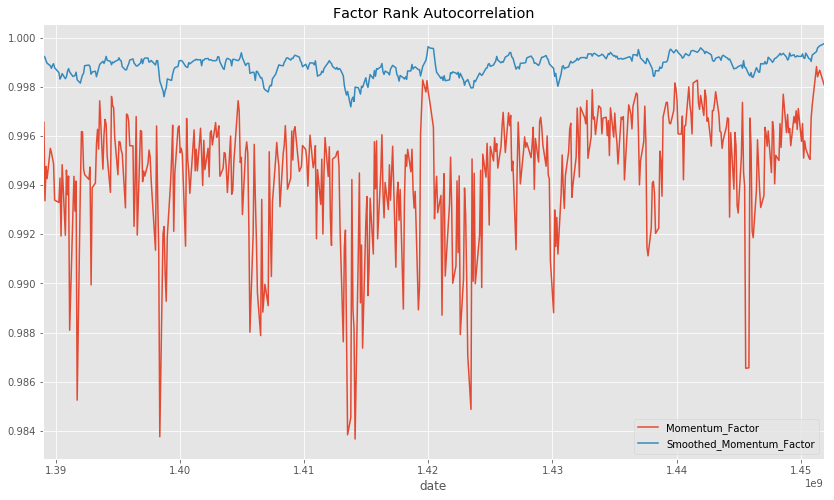

In [27]:
df_ls_fra.plot(title="Factor Rank Autocorrelation");

## Quiz 3
How would you compare the factor rank autocorrelation of the unsmoothed and smoothed factors?  How do you describe what this means in terms of potential transaction costs?

## Answer 3 here
The FRA of the smoothed factor is higher compared to the unsmoothed factor. This potentially means less trading and therefore lower transaction costs.

## Solution notebook
[The solution notebook is here.](turnover_solution.ipynb)